In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import GCNConv
from sklearn.ensemble import RandomForestClassifier
torch.cuda.empty_cache()
device=torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

d:\Anaconda\envs\AL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None
    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels * reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels * reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw
        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale
class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )
class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale
class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False, no_channel=False):
        super(CBAM, self).__init__()
        if not no_channel:
            self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out
class GCNModel(nn.Module):
    def __init__(self, fm,fd,miRNA_number,disease_number,gcn_layers,out_channels):
        super(GCNModel, self).__init__()
        self.fm=fm
        self.fd=fd
        self.miRNA_number=miRNA_number
        self.disease_number=disease_number
        self.gcn_layers=gcn_layers
        self.out_channels=out_channels

        self.x_m=nn.Parameter(torch.randn(self.miRNA_number,self.fm))
        self.x_d=nn.Parameter(torch.randn(self.disease_number,self.fd))
        
        self.gcn_x1_f = GCNConv(self.fm, self.fm)
        self.gcn_x2_f = GCNConv(self.fm, self.fm)
        self.gcn_x1_s = GCNConv(self.fm, self.fm)
        self.gcn_x2_s = GCNConv(self.fm, self.fm)
        self.gcn_y1_f = GCNConv(self.fd, self.fd)
        self.gcn_y2_f = GCNConv(self.fd, self.fd)
        self.gcn_y1_s = GCNConv(self.fd, self.fd)
        self.gcn_y2_s = GCNConv(self.fd, self.fd)

        self.cbamx = CBAM(1 * self.gcn_layers, 5, no_spatial=False)
        self.cbamy = CBAM(1 * self.gcn_layers, 5, no_spatial=False)
        self.cnn_x = nn.Conv2d(in_channels=1 * self.gcn_layers, out_channels=self.out_channels,
                                kernel_size=(self.fm, 1), stride=1, bias=True)
        self.cnn_y = nn.Conv2d(in_channels=1 * self.gcn_layers, out_channels=self.out_channels,
                                kernel_size=(self.fd, 1), stride=1, bias=True)

    def forward(self,data):
        x_m_f1 = torch.relu(self.gcn_x1_f(self.x_m, data['mm_f']['edges'], data['mm_f']['edge_value']))
        x_m_f2 = torch.relu(self.gcn_x2_f(x_m_f1, data['mm_f']['edges'], data['mm_f']['edge_value']))

        y_d_f1 = torch.relu(self.gcn_y1_f(self.x_d, data['dd_f']['edges'], data['dd_f']['edge_value']))
        y_d_f2 = torch.relu(self.gcn_y2_f(y_d_f1, data['dd_f']['edges'], data['dd_f']['edge_value']))

        XM = torch.cat((x_m_f1, x_m_f2), 1).t()
        YD = torch.cat((y_d_f1, y_d_f2), 1).t()
        XM = XM.view(1, 1 * self.gcn_layers, self.fm, -1)
        YD = YD.view(1, 1 * self.gcn_layers, self.fd, -1)
        XM_channel_attention = self.cbamx(XM)
        YD_channel_attention = self.cbamy(YD)
        x = self.cnn_x(XM_channel_attention)
        x = x.view(self.out_channels, self.miRNA_number).t()
        y = self.cnn_y(YD_channel_attention)
        y = y.view(self.out_channels, self.disease_number).t()
        return x.mm(y.t()), x, y
# data={'mm_f':{},'dd_f':{}}
# data['mm_f']['edges']=torch.cat([torch.arange(3).reshape(1,3),torch.arange(3).reshape(1,3)],dim=0).cuda()
# data['mm_f']['edge_value']=torch.ones(3).cuda()
# data['dd_f']['edges']=torch.cat([torch.arange(3).reshape(1,3),torch.arange(3).reshape(1,3)],dim=0).cuda()
# data['dd_f']['edge_value']=torch.ones(3).cuda()
# net=GCNModel(128,128,834,138,2,256).cuda()
# net(data)

In [3]:
_,cd,fea,tri,tei=torch.load('./data_circ/dataset/circ_CNN.pth')
res=[]
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
for i in range(5):
    print('cross:%d'%i)
    net=GCNModel(128,128,834,138,2,256).to(device)
    optimizer=torch.optim.Adam(net.parameters(),5e-3)#weight_decay=5e-5
    feat=fea[i][:834,834:834+138].float()
    data_matrix=fea[i][:834,:834]
    input={'mm_f':{},'mm_g':{},'dd_f':{},'dd_g':{}}
    input['mm_f']['edges']=torch.argwhere(data_matrix>0).t()
    input['mm_f']['edge_value']=data_matrix[input['mm_f']['edges'][0], input['mm_f']['edges'][1]].float().to(device)
    input['mm_f']['edges']=input['mm_f']['edges'].to(device)

    data_matrix=fea[i][834:834+138,834:834+138]
    input['dd_f']['edges']=torch.argwhere(data_matrix>0).t()
    input['dd_f']['edge_value']=data_matrix[input['dd_f']['edges'][0], input['dd_f']['edges'][1]].float().to(device)
    input['dd_f']['edges']=input['dd_f']['edges'].to(device)
    for e in range(100):
        score,x,y=net(input)
        loss = criterion(score, feat.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(loss.item())
    score,x,y=net(input)
    x,y=x.detach().cpu(),y.detach().cpu()
    clf = RandomForestClassifier(n_estimators=200,n_jobs=11,max_depth=20)
    clf.fit(torch.cat([x[tri[i][0,:]],y[tri[i][1,:]]],dim=1), cd[tri[i][0,:],tri[i][1,:]])
    y_prob = clf.predict_proba(torch.cat([x[tei[i][0,:]],y[tei[i][1,:]]],dim=1))
    res.append([y_prob[:,0],cd[tei[i][0,:],tei[i][1,:]]])

cross:0
cross:1
cross:2
cross:3
cross:4


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve
import warnings
warnings.filterwarnings("ignore")
def roc_pr4_folder(test_x_ys, labels, pred_ys, ass_mat_shape):
	labels_mat, pred_ys_mat, test_num= torch.zeros((ass_mat_shape)) -1, torch.zeros((ass_mat_shape)) -1, len(labels)
	for i in range(test_num):
		labels_mat[test_x_ys[i][0], test_x_ys[i][1]]= labels[i]
		pred_ys_mat[test_x_ys[i][0], test_x_ys[i][1]]= pred_ys[i]
	bool_mat4test= (labels_mat!= -1)
	fpr_ls, tpr_ls, recall_ls, prec_ls, effective_rows_len = [], [], [], [], 0
	for i in range(ass_mat_shape[0]):
		if (labels_mat[i][bool_mat4test[i]]== 1).sum()> 0:
			effective_rows_len+= 1
			labels4test1rowi= labels_mat[i][bool_mat4test[i]]
			pred_y4test1rowi= pred_ys_mat[i][bool_mat4test[i]]
			fpr4rowi, tpr4rowi, _= roc_curve(labels4test1rowi, pred_y4test1rowi)
			fpr_ls.append(fpr4rowi)
			tpr_ls.append(tpr4rowi)
			precision4rowi, recall4rowi, _= precision_recall_curve(labels4test1rowi, pred_y4test1rowi)
			precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
			prec_ls.append(precision4rowi[::-1])
			recall_ls.append(recall4rowi[::-1])
	mean_fpr, mean_recall= np.linspace(0, 1, 100), np.linspace(0, 1, 100)
	tpr_ls4mean_tpr, prec_ls4mean_prec= [], []
	for i in range(effective_rows_len):
		tpr_ls4mean_tpr.append(np.interp(mean_fpr, fpr_ls[i], tpr_ls[i]))
		prec_ls4mean_prec.append(np.interp(mean_fpr, recall_ls[i], prec_ls[i]))
	mean_tpr, mean_prec= np.mean(tpr_ls4mean_tpr, axis= 0), np.mean(prec_ls4mean_prec, axis= 0)
	print(f'ROC平均值auc(mean_fpr, mean_tpr): {auc(mean_fpr, mean_tpr)}')
	print(f'pr平均值auc(mean_recall, mean_prec)：{auc(mean_recall, mean_prec)}')
	return mean_fpr, mean_tpr, mean_recall, mean_prec
def roc_pr4cross_val(mean_fpr_ts, mean_tpr_ts, mean_recall_ts, mean_prec_ts, k_fold):
	mean_fpr, mean_tpr, mean_recall, mean_prec= mean_fpr_ts[0], torch.mean(mean_tpr_ts, dim= 0), mean_recall_ts[0], torch.mean(mean_prec_ts, dim= 0)
	torch.save([mean_fpr, mean_tpr, mean_recall, mean_prec],'./res/data/MDGF_MCEC.pkl')
	aucs4roc, aucs4pr= [], []
	for i in range(k_fold):
		aucs4roc.append(auc(mean_fpr_ts[i], mean_tpr_ts[i]))
		plt.plot(mean_fpr_ts[i], mean_tpr_ts[i], lw= 1, alpha= 0.3, label= 'ROC fold %d (AUC= %0.3f)' % (i+ 1, aucs4roc[i]))
	aucs4roc_std, mean_auc4roc= np.std(aucs4roc), auc(mean_fpr, mean_tpr)
	plt.plot(mean_fpr, mean_tpr, color= 'b', lw= 2, alpha= 0.8, label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc4roc, aucs4roc_std))
	plt.title('roc curve')
	plt.xlabel('fpr')
	plt.ylabel('tpr')
	plt.axis([0, 1, 0, 1])
	plt.legend(loc= 'lower right')
	plt.show()
	for i in range(k_fold):
		aucs4pr.append(auc(mean_recall_ts[i], mean_prec_ts[i]))
		plt.plot(mean_recall_ts[i], mean_prec_ts[i], lw= 1, alpha= 0.3, label= 'PR fold %d (AUPR= %0.3f)' % (i+ 1, aucs4pr[i]))
	aucs4pr_std, mean_auc4pr= np.std(aucs4pr), auc(mean_recall, mean_prec)
	plt.plot(mean_recall, mean_prec, color= 'b', lw= 2, alpha= 0.8, label= r'Mean PR (AUPR = %0.3f $\pm$ %0.3f)' % (mean_auc4pr, aucs4pr_std))
	plt.title('pr curve')
	plt.xlabel('recall')
	plt.ylabel('precision')
	plt.axis([0, 1, 0, 1])
	plt.legend(loc= 'lower right')
	plt.show()

ROC平均值auc(mean_fpr, mean_tpr): 0.6713330756129705
pr平均值auc(mean_recall, mean_prec)：0.12915908752511984
ROC平均值auc(mean_fpr, mean_tpr): 0.7358303202383898
pr平均值auc(mean_recall, mean_prec)：0.2516005756069692
ROC平均值auc(mean_fpr, mean_tpr): 0.7176126761940431
pr平均值auc(mean_recall, mean_prec)：0.14468870930658478
ROC平均值auc(mean_fpr, mean_tpr): 0.7095849133770843
pr平均值auc(mean_recall, mean_prec)：0.20278559674543176
ROC平均值auc(mean_fpr, mean_tpr): 0.7653119995203208
pr平均值auc(mean_recall, mean_prec)：0.2676026087687114


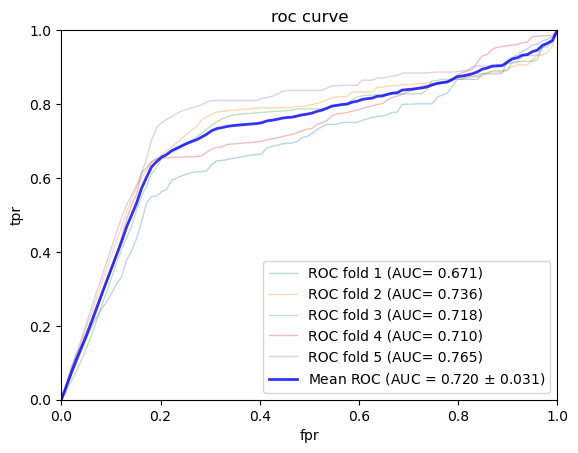

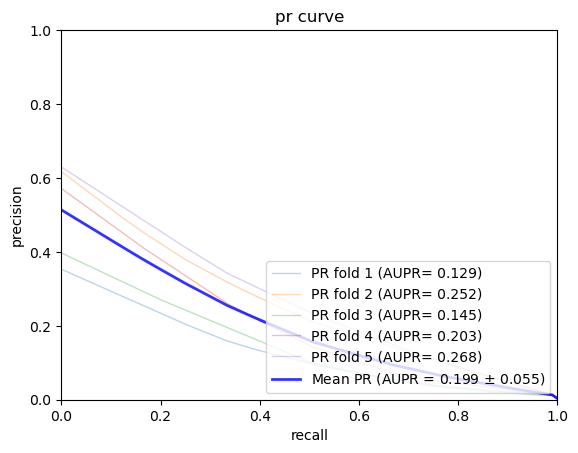

In [5]:
mean_fprs, mean_tprs, mean_recalls, mean_precs= [], [], [], []
_,cd,fea,tri,tei=torch.load('./data_circ/dataset/circ_CNN.pth')
for i in range(5):
    # pred, y=torch.load('./data_circ/final_model/circ_plt_%d'%i)
    pred, y=res[i]
    test_idx= tei[i].T
    test_idx= torch.stack([test_idx[:, 1], test_idx[:, 0]], dim= 1)
    mean_fpr, mean_tpr, mean_recall, mean_prec= roc_pr4_folder(test_idx, y, pred, (138, 834))
    mean_fprs.append(torch.tensor(mean_fpr)); mean_tprs.append(torch.tensor(mean_tpr)); mean_recalls.append(torch.tensor(mean_recall)); mean_precs.append(torch.tensor(mean_prec))
mean_fpr_ts, mean_tpr_ts, mean_recall_ts, mean_prec_ts= torch.stack(mean_fprs), torch.stack(mean_tprs), torch.stack(mean_recalls, dim= 0), torch.stack(mean_precs, dim= 0)
roc_pr4cross_val(mean_fpr_ts, mean_tpr_ts, mean_recall_ts, mean_prec_ts, 5)